In [205]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch
from mplsoccer import Pitch

In [206]:
#define the paths for la liga 20/21
matches_path='./open-data/data/matches/11/90.json'
events_dir='./open-data/data/events'

In [207]:
#load the match data and convert it to dataframe
with open(matches_path, 'r') as f:
    matches=json.load(f)
matches_df=pd.json_normalize(matches)
#print(matches_df.head())

In [208]:
match_ids=matches_df['match_id'].tolist()

all_events=[]

for match_id in match_ids:
    event_file_path=os.path.join(events_dir, f"{match_id}.json")

    if os.path.exists(event_file_path):
        with open(event_file_path, 'r') as f:
            events=json.load(f)
            
        events_df=pd.json_normalize(events)
        all_events.append(events_df)
    else:
        print(f"Event data not found for match {match_id}")

if all_events:
    events_df=pd.concat(all_events, ignore_index=True)
    #print(events_df.head)
#else:
    #print("No event data found.")

In [209]:
relevant_events_df=events_df[events_df['type.name'].isin(['Pass', 'Carry', 'Shot'])]

#get start coordinates and end coordinates (for passes/carries)
x_start = relevant_events_df['location'].apply(lambda loc: loc[0] if isinstance(loc, list) else None)
y_start = relevant_events_df['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)
x_end = relevant_events_df['pass.end_location'].apply(lambda loc: loc[0] if isinstance(loc, list) else None)
y_end = relevant_events_df['pass.end_location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)

#combine new cols into original df
relevant_events_df = pd.concat([relevant_events_df, x_start.rename('x_start'), y_start.rename('y_start'), x_end.rename('x_end'), y_end.rename('y_end')], axis=1)

#missing vals
relevant_events_df.fillna(0, inplace=True)


#debugging
#print("x_start values:")
#print(relevant_events_df['x_start'].describe())
#print("y_start values:")
#print(relevant_events_df['y_start'].describe())

In [216]:
#make da grid


pitch_length = 120
pitch_width = 80

# Define the number of bins (12x8 grid)
grid_x = 20  # You can adjust this to more fine-grained bins if needed
grid_y = 15

# Manually define the bins for x and y based on the pitch dimensions
x_bins = np.linspace(0, pitch_length, grid_x + 1)  # 0 to 120
y_bins = np.linspace(0, pitch_width, grid_y + 1)   # 0 to 80

# Apply pd.cut to reassign the zones explicitly
relevant_events_df['zone_x'] = pd.cut(relevant_events_df['x_start'], bins=x_bins, labels=False, include_lowest=True)
relevant_events_df['zone_y'] = pd.cut(relevant_events_df['y_start'], bins=y_bins, labels=False, include_lowest=True)

In [217]:
zone_transitions = relevant_events_df.groupby(['zone_x', 'zone_y']).size()
zone_shots = relevant_events_df[relevant_events_df['type.name'] == 'Shot'].groupby(['zone_x', 'zone_y']).size()


xT_values = zone_shots / zone_transitions
xT_values.fillna(0, inplace=True)

# Create a pivot table to map xT values into a matrix
xT_matrix = xT_values.unstack(level='zone_y').fillna(0)

In [218]:
xT_matrix=xT_values.unstack(level='zone_y').fillna(0)

pitch=Pitch(line_color='black', pitch_type='statsbomb', half=True)
fig, ax = (10, 7)

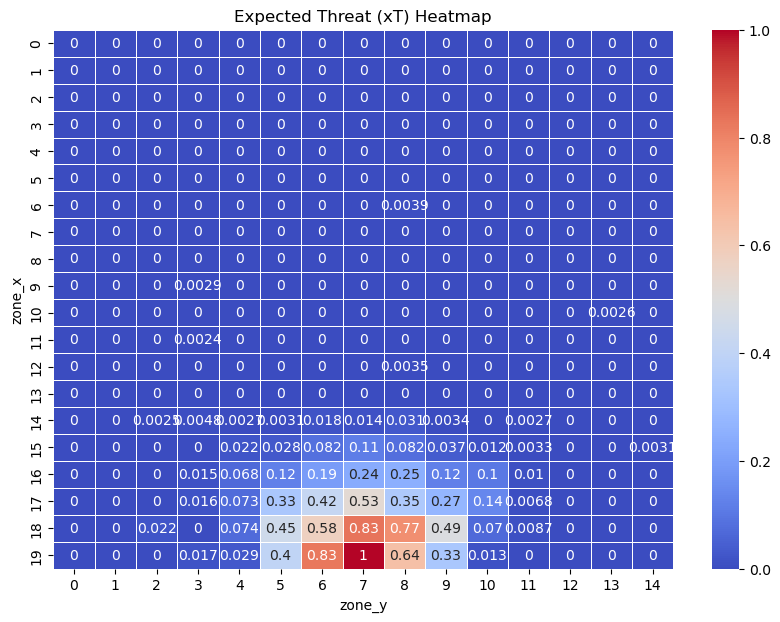

In [219]:
import seaborn as sns

#use seaborn to plot a heatmap directly from the xT matrix
plt.figure(figsize=(10, 7))
sns.heatmap(xT_matrix, cmap='coolwarm', linewidths=.5, annot=True)

plt.title('Expected Threat (xT) Heatmap')
plt.show()

In [ ]:
#now i wanted to leverage some ML techniques with xT

In [259]:
#1. simple linear regression for expected threat
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def get_xT_value(row):
    try:
        return xT_matrix.iloc[row['zone_x'], row['zone_y']]
    except:
        return 0  # in case of NaN

# apply the function to create a new column 'xT_value'
relevant_events_df['xT_value'] = relevant_events_df.apply(get_xT_value, axis=1)

# step 2: the same number of rows in both X and y
X = relevant_events_df[['x_start', 'y_start']]  # features
y = relevant_events_df['xT_value']  # target (xT values)

# step 3: split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# step 4: train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

#evaluate  model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

print(f"Model Coefficients: {model.coef_}")

new_events = pd.DataFrame({
    'x_start': [50, 75, 100],  # Horizontal positions on the pitch
    'y_start': [30, 20, 40]    # Vertical positions on the pitch
})

# Use the trained model to predict xT for these new events
xT_predictions = model.predict(new_events)
print(xT_predictions)

Mean Squared Error: 0.0036
Model Coefficients: [6.27482986e-04 3.08401366e-06]
[0.00401432 0.01967055 0.03541931]


In [225]:
#2. logistic regression to predict goal probability
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

relevant_events_df['is_goal'] = relevant_events_df['shot.outcome.name'].apply(lambda x: 1 if x == 'Goal' else 0)

X = relevant_events_df[['x_start', 'y_start']]
y = relevant_events_df['is_goal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

#evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

#predict probabilities
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]  # Probability of class 1 (goal)

Accuracy: 0.9985


Accuracy: 0.5641
Precision: 0.3043
Recall: 0.8750


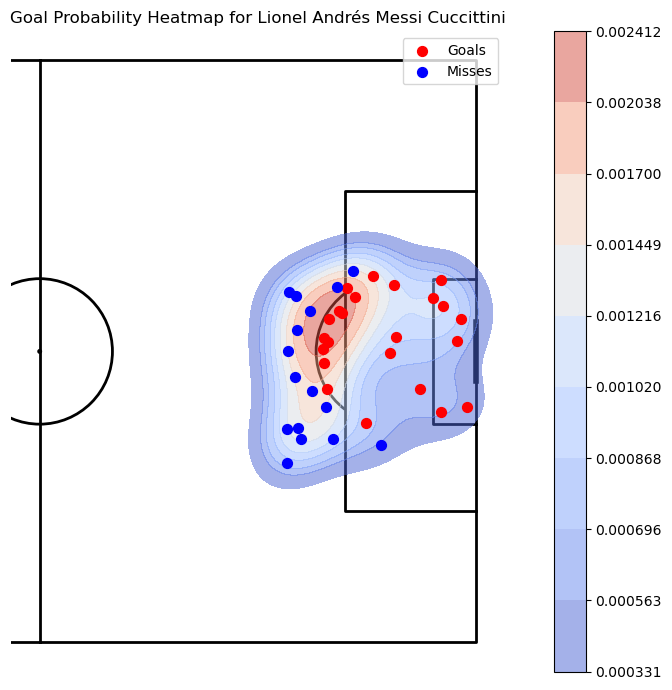

In [257]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
#filter dataset for messi

player_name = "Lionel Andrés Messi Cuccittini"
player_id = relevant_events_df[relevant_events_df['player.name'] == player_name]['player.id'].unique()[0]
messi_events_df = relevant_events_df[relevant_events_df['player.id'] == player_id]
messi_shots_df = messi_events_df[messi_events_df['type.name'] == 'Shot']

#print(messi_shots_df[['minute', 'x_start', 'y_start', 'shot.outcome.name']].head())

#add a binary column to see if it's a goal or a miss
messi_shots_df.loc[:, 'is_goal'] = messi_shots_df['shot.outcome.name'].apply(lambda x: 1 if x == 'Goal' else 0)
#add distance to goal and angle to goal as features
goal_x, goal_y = 120, 40  #goal center coordinates
distance_to_goal = np.sqrt((goal_x - messi_shots_df['x_start'])**2 + (goal_y - messi_shots_df['y_start'])**2)
angle_to_goal = np.arctan2(np.abs(goal_y - messi_shots_df['y_start']), np.abs(goal_x - messi_shots_df['x_start']))
messi_shots_df = pd.concat([messi_shots_df, distance_to_goal.rename('distance_to_goal'), angle_to_goal.rename('angle_to_goal')], axis=1)

# Select features for the model (x_start, y_start)
X = messi_shots_df[['x_start', 'y_start', 'distance_to_goal', 'angle_to_goal']].fillna(0)
y = messi_shots_df['is_goal']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#create and train the logistic regression model with balanced classweights to handle imbalances
log_reg = LogisticRegression(class_weight='balanced')
log_reg.fit(X_train, y_train)

y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

threshold=0.45
y_pred = (y_pred_prob >= threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}") #number of correct predictions
print(f"Precision: {precision:.4f}") #number of goals that the model predicted that were actually goals
print(f"Recall: {recall:.4f}") #how many of the actual goals it predicts

#2d heatmap for messi goal probability
pitch = Pitch(line_color='black', pitch_type='statsbomb', half=True)
fig, ax = pitch.draw(figsize=(10, 7))

sns.kdeplot(x=X_test['x_start'], y=X_test['y_start'], fill=True, cmap='coolwarm', 
            ax=ax, cbar=True, alpha=0.5, thresh=0.1, zorder=2)

# Overlay goals and misses as scatter plots
goals = X_test[y_pred == 1]
misses = X_test[y_pred == 0]
ax.scatter(goals['x_start'], goals['y_start'], color='red', s=50, zorder=3, label='Goals')
ax.scatter(misses['x_start'], misses['y_start'], color='blue', s=50, zorder=3, label='Misses')

plt.title(f'Goal Probability Heatmap for {player_name}')
plt.legend(loc='upper right')
plt.show()

In [245]:
print(messi_shots_df['is_goal'].value_counts())

is_goal
0    165
1     30
Name: count, dtype: int64


In [227]:
# List unique player names to find how Messi is represented
player_names = relevant_events_df['player.name'].unique()
print(player_names)

['Antoine Griezmann' 'Sergio Busquets i Burgos' 'Frenkie de Jong'
 'Gerard Piqué Bernabéu' 'Clément Lenglet' 'Jordi Alba Ramos'
 'Sergi Roberto Carnicer' 'Lionel Andrés Messi Cuccittini'
 'Rubén Duarte Sánchez' 'Deyverson Brum Silva Acosta' 'Anssumane Fati'
 'Ousmane Dembélé' 'Edgar Antonio Méndez Ortega' 'Tomás Pina Isla'
 'Florian Grégoire Claude Lejeune' 'Joaquín Navarro Jiménez'
 'Rodrigo Andrés Battaglia' 'Víctor Laguardia Cisneros'
 'José Ignacio Peleteiro Ramallo' 'Luis Jesús Rioja González'
 'Fernando Pacheco Flores' 'Norberto Murara Neto' 'Miralem Pjanić'
 'Pedro González López' 'Francisco António Machado Mota de Castro Trincão'
 'Martín Aguirregabiria Padilla' 'José Luis Sanmartín Mato'
 'Tomas Franco Tavares' 'Sergino Dest' 'Manuel Alejandro García Sánchez'
 'Martin Braithwaite Christensen' 'Adrián Marín Gómez'
 'Óscar Mingueza García' 'Samuel Yves Umtiti' 'Rui Tiago Dantas da Silva'
 'Germán Sánchez Barahona' 'Yangel Clemente Herrera Ravelo'
 'Dimitri Foulquier' 'Marc-André